# Implementing Transformer Architecture

## Paper Reference
- ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017)
- Key sections: 
  - 3.1: Encoder and Decoder Stacks
  - 3.2: Attention Mechanism
  - 3.3: Position-wise Feed-Forward Networks
  - 3.4: Embeddings and Softmax
  - 3.5: Positional Encoding
  - 5.4: Regularization (dropout strategy)

## Implementation Strategy
Breaking down the architecture into manageable pieces and gradually adding complexity:

1. Start with foundational components:
   - Embedding + Positional Encoding
   - Single-head self-attention
   
2. Build up attention mechanism:
   - Extend to multi-head attention
   - Add cross-attention capability
   - Implement attention masking

3. Construct larger components:
   - Encoder (self-attention + FFN)
   - Decoder (masked self-attention + cross-attention + FFN)
   
4. Combine into final architecture:
   - Encoder-Decoder stack
   - Full Transformer with input/output layers


## Testing Strategy
- Test each component independently
- Verify shape preservation
- Check attention patterns
- Confirm mask effectiveness
- Validate gradient flow
- Monitor numerical stability

## Code Section

### Embedding and Positional Encoding
This implements the input embedding from Section 3.4 and positional encoding from Section 3.5 of the paper. Key points:
- Embedding dimension can differ from model dimension (using projection)
- Positional encoding uses sine and cosine functions
- Scale embeddings by √d_model
- Apply dropout to the sum of embeddings and positional encodings

In [1]:
import math
import torch
import torch.nn as nn

class EmbeddingWithProjection(nn.Module):
    def __init__(self, vocab_size, d_embed, d_model,  
                 max_position_embeddings =512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_embed = d_embed
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.projection = nn.Linear(self.d_embed, self.d_model)
        self.scaling = float(math.sqrt(self.d_model))

        self.layernorm = nn.LayerNorm(self.d_model)
        self.dropout = nn.Dropout(p=dropout)

    @staticmethod
    def create_positional_encoding(seq_length, d_model, batch_size=1):
        # Create position indices: [seq_length, 1]
        position = torch.arange(seq_length).unsqueeze(1).float()
        
        # Create dimension indices: [1, d_model//2]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * 
            (-math.log(10000.0) / d_model)
        )
        
        # Create empty tensor: [seq_length, d_model]
        pe = torch.zeros(seq_length, d_model)
        
        # Compute sin and cos
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and expand: [batch_size, seq_length, d_model]
        pe = pe.unsqueeze(0).expand(batch_size, -1, -1)
        
        return pe

    
    
    def forward(self, x):
        assert x.dtype == torch.long, f"Input tensor must have dtype torch.long, got {x.dtype}"
        batch_size, seq_length = x.size() # [batch, seq_length]

        # token embedding
        token_embedding = self.embedding(x)                                                            #[2, 16, 1024]     
        # project the scaled token embedding to the d_model space
        token_embedding =  self.projection(token_embedding) * self.scaling                             #[2, 16, 768]

        # add positional encodings to projected, 
        # scaled embeddings before applying layer norm and dropout.
        positional_encoding = self.create_positional_encoding(seq_length, self.d_model, batch_size)    #[2, 16, 768]
        
        # In addition, we apply dropout to the sums of the embeddings 
        # in both the encoder and decoder stacks. For the base model, we use a rate of Pdrop = 0.1.
        normalized_sum = self.layernorm(token_embedding + positional_encoding)
        final_output = self.dropout(normalized_sum)
        return final_output

### Transformer Attention
Implements the core attention mechanism from Section 3.2.1. Formula:

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^{\mathsf{T}}}{\sqrt{d_k}}\right)V
$$

Key points:
- Supports both self-attention and cross-attention
- Multi-head attention implementation per section 3.2.2
- Handles different sequence lengths for encoder/decoder
- Scales dot products by 1/√d_k
- Applies attention masking before softmax
- Applies dropout after softmax

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class TransformerAttention(nn.Module):
    """
    Transformer Scaled Dot Product Attention Module
    Args:
        d_model: Total dimension of the model.
        num_head: Number of attention heads.
        dropout: Dropout rate for attention scores.
        bias: Whether to include bias in linear projections.

    Inputs:
        sequence: input sequence for self-attention and the query for cross-attention
        key_value_state: input for the key, values for cross-attention
    """
    def __init__(self, d_model, num_head, dropout=0.1, bias=True): # infer d_k, d_v, d_q from d_model
        super().__init__()  # Missing in the original implementation
        assert d_model % num_head == 0, "d_model must be divisible by num_head"
        self.d_model = d_model
        self.num_head = num_head
        self.d_head=d_model//num_head
        self.dropout_rate = dropout  # Store dropout rate separately

        # linear transformations
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        self.output_proj = nn.Linear(d_model, d_model, bias=bias)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Initiialize scaler
        self.scaler = float(1.0 / math.sqrt(self.d_head)) # Store as float in initialization
        

    def forward(self, sequence, key_value_states = None, att_mask=None):
        """Input shape: [batch_size, seq_len, d_model=num_head * d_head]"""
        batch_size, seq_len, model_dim = sequence.size()

        # Check only critical input dimensions
        assert model_dim == self.d_model, f"Input dimension {model_dim} doesn't match model dimension {self.d_model}"
        if key_value_states is not None:
            assert key_value_states.size(-1) == self.d_model, \
            f"Cross attention key/value dimension {key_value_states.size(-1)} doesn't match model dimension {self.d_model}"


        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        
        # Linear projections and reshape for multi-head
        Q_state = self.q_proj(sequence)
        if is_cross_attention:
            kv_seq_len = key_value_states.size(1)
            K_state = self.k_proj(key_value_states)
            V_state = self.v_proj(key_value_states)
        else:
            kv_seq_len = seq_len
            K_state = self.k_proj(sequence)
            V_state = self.v_proj(sequence)

        #[batch_size, self.num_head, seq_len, self.d_head]
        Q_state = Q_state.view(batch_size, seq_len, self.num_head, self.d_head).transpose(1,2) 
            
        # in cross-attention, key/value sequence length might be different from query sequence length
        K_state = K_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1,2)
        V_state = V_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1,2)

        # Scale Q by 1/sqrt(d_k)
        Q_state = Q_state * self.scaler
    
    
        # Compute attention matrix: QK^T
        self.att_matrix = torch.matmul(Q_state, K_state.transpose(-1,-2)) 

    
        # apply attention mask to attention matrix
        if att_mask is not None and not isinstance(att_mask, torch.Tensor):
            raise TypeError("att_mask must be a torch.Tensor")

        if att_mask is not None:
            self.att_matrix = self.att_matrix + att_mask
        
        # apply softmax to the last dimension to get the attention score: softmax(QK^T)
        att_score = F.softmax(self.att_matrix, dim = -1)
    
        # apply drop out to attention score
        att_score = self.dropout(att_score)
    
        # get final output: softmax(QK^T)V
        att_output = torch.matmul(att_score, V_state)
    
        # concatinate all attention heads
        att_output = att_output.transpose(1, 2)
        att_output = att_output.contiguous().view(batch_size, seq_len, self.num_head*self.d_head) 
    
        # final linear transformation to the concatenated output
        att_output = self.output_proj(att_output)

        assert att_output.size() == (batch_size, seq_len, self.d_model), \
        f"Final output shape {att_output.size()} incorrect"

        return att_output

### Feed-Forward Network (FFN)
Implements the position-wise feed-forward network from Section 3.3: FFN(x) = max(0, xW₁ + b₁)W₂ + b₂

Key points:
- Two linear transformations with ReLU in between
- Inner layer dimension (d_ff) is typically 2048
- Applied identically to each position

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FFN(nn.Module):
    """
    Position-wise Feed-Forward Networks
    This consists of two linear transformations with a ReLU activation in between.
    
    FFN(x) = max(0, xW1 + b1 )W2 + b2
    d_model: embedding dimension (e.g., 512)
    d_ff: feed-forward dimension (e.g., 2048)
    
    """
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.d_model=d_model
        self.d_ff= d_ff
        
        # Linear transformation y = xW+b
        self.fc1 = nn.Linear(self.d_model, self.d_ff, bias = True)
        self.fc2 = nn.Linear(self.d_ff, self.d_model, bias = True)
        
        # for potential speed up
        # Pre-normalize the weights (can help with training stability)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, input):
        # check input and first FF layer dimension matching
        batch_size, seq_length, d_input = input.size()
        assert self.d_model == d_input, "d_model must be the same dimension as the input"

        # First linear transformation followed by ReLU
        # There's no need for explicit torch.max() as F.relu() already implements max(0,x)
        f1 = F.relu(self.fc1(input))

        # max(0, xW_1 + b_1)W_2 + b_2 
        f2 =  self.fc2(f1)

        return f2

        

In [4]:
net = FFN(  d_model = 512,  d_ff =2048)
print(net)

FFN(
  (fc1): Linear(in_features=512, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
)


### Transformer Encoder
Implements single encoder layer from Section 3.1, consisting of:
- Multi-head self-attention
- Position-wise feed-forward network
- Residual connections and layer normalization

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    """
    Encoder layer of the Transformer
    Sublayers: TransformerAttention
               Residual LayerNorm
               FNN
               Residual LayerNorm
    Args:
            d_model: 512 model hidden dimension
            d_embed: 512 embedding dimension, same as d_model in transformer framework
            d_ff: 2048 hidden dimension of the feed forward network
            num_head: 8 Number of attention heads.
            dropout:  0.1 dropout rate 
            
            bias: Whether to include bias in linear projections.
              
    """

    def __init__(
        self, d_model, d_ff,
        num_head, dropout=0.1,
        bias=True
    ):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        
        # attention sublayer
        self.att = TransformerAttention(
            d_model = d_model,
            num_head = num_head,
            dropout = dropout,
            bias = bias
        )
        
        # FFN sublayer
        self.ffn = FFN(
            d_model = d_model,
            d_ff = d_ff
        )

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # layer-normalization layer
        self.LayerNorm_att = nn.LayerNorm(self.d_model)
        self.LayerNorm_ffn = nn.LayerNorm(self.d_model)

        
    def forward(self, embed_input, padding_mask=None):
       
        batch_size, seq_len, _ = embed_input.size()
        
        ## First sublayer: self attion 
        att_sublayer = self.att(sequence = embed_input, key_value_states = None, 
                                att_mask = padding_mask)  # [batch_size, sequence_length, d_model]
        
        # apply dropout before layer normalization for each sublayer
        att_sublayer = self.dropout(att_sublayer)
        # Residual layer normalization
        att_normalized = self.LayerNorm_att(embed_input + att_sublayer)           # [batch_size, sequence_length, d_model]
        
        ## Second sublayer: FFN
        ffn_sublayer = self.ffn(att_normalized)                                   # [batch_size, sequence_length, d_model]
        ffn_sublayer = self.dropout(ffn_sublayer)
        ffn_normalized = self.LayerNorm_ffn(att_normalized + ffn_sublayer )       # [batch_size, sequence_length, d_model]
    

        return ffn_normalized

In [6]:
net = TransformerEncoder( d_model = 512, d_ff =2048, num_head=8, dropout=0.1, bias=True )
print(net)

TransformerEncoder(
  (att): TransformerAttention(
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (output_proj): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FFN(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (LayerNorm_att): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_ffn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


### Transformer Decoder
Implements decoder layer from Section 3.1, with three sub-layers:
- Masked multi-head self-attention
- Multi-head cross-attention with encoder output
- Position-wise feed-forward network

Key points:
- Self-attention uses causal masking
- Cross-attention allows attending to all encoder outputs
- Each sub-layer followed by residual connection and layer normalization
- Apply dropout to the output of previous sub-layer before residual connection and layer normalization
- Key implementation detail for causal masking:
  - Create causal mask using upper triangular matrix:
  ```python
  mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
  mask = mask.masked_fill(mask == 1, float('-inf'))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerDecoder(nn.Module):
    """
    Decoder layer of the Transformer
    Sublayers: TransformerAttention with self-attention
               Residual LayerNorm
               TransformerAttention with cross-attention
               Residual LayerNorm
               FNN
               Residual LayerNorm
    Args:
            d_model: 512 model hidden dimension
            d_embed: 512 embedding dimension, same as d_model in transformer framework
            d_ff: 2048 hidden dimension of the feed forward network
            num_head: 8 Number of attention heads.
            dropout:  0.1 dropout rate 
            
            bias: Whether to include bias in linear projections.
              
    """

    def __init__(
        self, d_model, d_ff,
        num_head, dropout=0.1,
        bias=True
    ):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        
        # attention sublayer
        self.att = TransformerAttention(
            d_model = d_model,
            num_head = num_head,
            dropout = dropout,
            bias = bias
        )
        
        # FFN sublayer
        self.ffn = FFN(
            d_model = d_model,
            d_ff = d_ff
        )

        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # layer-normalization layer
        self.LayerNorm_att1 = nn.LayerNorm(self.d_model)
        self.LayerNorm_att2 = nn.LayerNorm(self.d_model)
        self.LayerNorm_ffn = nn.LayerNorm(self.d_model)

    @staticmethod
    def create_causal_mask(seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    
    def forward(self, embed_input, cross_input, padding_mask=None):
        """
        Args:
        embed_input: Decoder input sequence [batch_size, seq_len, d_model]
        cross_input: Encoder output sequence [batch_size, encoder_seq_len, d_model]
        casual_attention_mask: Causal mask for self-attention [batch_size, seq_len, seq_len]
        padding_mask: Padding mask for cross-attention [batch_size, seq_len, encoder_seq_len]
        Returns:
        Tensor: Decoded output [batch_size, seq_len, d_model]
        """
        batch_size, seq_len, _ = embed_input.size()
        
        assert embed_input.size(-1) == self.d_model, f"Input dimension {embed_input.size(-1)} doesn't match model dimension {self.d_model}"
        assert cross_input.size(-1) == self.d_model, "Encoder output dimension doesn't match model dimension"


        # Generate and expand causal mask for self-attention
        causal_mask = self.create_causal_mask(seq_len).to(embed_input.device)  # [seq_len, seq_len]
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, seq_len, seq_len]


        ## First sublayer: self attion 
        # After embedding and positional encoding, input sequence feed into current attention sublayer
        # Or, the output of the previous encoder/decoder feed into current attention sublayer
        att_sublayer1 = self.att(sequence = embed_input, key_value_states = None, 
                                att_mask = causal_mask)  # [batch_size, num_head, sequence_length, d_model]
        # apply dropout before layer normalization for each sublayer
        att_sublayer1 = self.dropout(att_sublayer1)
        # Residual layer normalization
        att_normalized1 = self.LayerNorm_att1(embed_input + att_sublayer1)           # [batch_size, sequence_length, d_model]

        ## Second sublayer: cross attention
        # Query from the output of previous attention output, or training data
        # Key, Value from output of Encoder of the same layer
        att_sublayer2 = self.att(sequence = att_normalized1, key_value_states = cross_input, 
                                att_mask = padding_mask)  # [batch_size, sequence_length, d_model]
        # apply dropout before layer normalization for each sublayer
        att_sublayer2 = self.dropout(att_sublayer2)
        # Residual layer normalization
        att_normalized2 = self.LayerNorm_att2(att_normalized1 + att_sublayer2)           # [batch_size, sequence_length, d_model]
        
        
        # Third sublayer: FFN
        ffn_sublayer = self.ffn(att_normalized2)                                   # [batch_size, sequence_length, d_model]
        ffn_sublayer = self.dropout(ffn_sublayer)
        ffn_normalized = self.LayerNorm_ffn(att_normalized2 + ffn_sublayer )       # [batch_size, sequence_length, d_model]
    

        return ffn_normalized

In [8]:
net = TransformerDecoder( d_model = 512, d_ff =2048, num_head=8, dropout=0.1, bias=True )
print(net)

TransformerDecoder(
  (att): TransformerAttention(
    (q_proj): Linear(in_features=512, out_features=512, bias=True)
    (k_proj): Linear(in_features=512, out_features=512, bias=True)
    (v_proj): Linear(in_features=512, out_features=512, bias=True)
    (output_proj): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): FFN(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (LayerNorm_att1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_att2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (LayerNorm_ffn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


### Encoder-Decoder Stack
Implements the full stack of encoder and decoder layers from Section 3.1.

Key points:
- Multiple encoder and decoder layers (typically 6)
- Each encoder output feeds into all decoder layers
- Maintains residual connections throughout the stack

In [9]:
class TransformerEncoderDecoder(nn.Module):
    """
    Encoder-Decoder stack of the Transformer
    Sublayers:  Encoder x 6
                Decoder x 6
    Args:
            d_model: 512 model hidden dimension
            d_embed: 512 embedding dimension, same as d_model in transformer framework
            d_ff: 2048 hidden dimension of the feed forward network
            num_head: 8 Number of attention heads.
            dropout:  0.1 dropout rate 
            
            bias: Whether to include bias in linear projections.
              
    """
    def __init__(
        self, num_layer,
        d_model, d_ff,
        num_head, dropout=0.1,
        bias=True
    ):
        super().__init__()
        self.num_layer = num_layer
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_head = num_head
        self.dropout = dropout
        self.bias = bias
        
        # Encoder stack
        self.encoder_stack = nn.ModuleList([ TransformerEncoder(
                                        d_model = self.d_model, 
                                        d_ff = self.d_ff,
                                        num_head = self.num_head, 
                                        dropout = self.dropout,
                                        bias = self.bias) for _ in range(self.num_layer)])

        # Decoder stack
        self.decoder_stack = nn.ModuleList([ TransformerDecoder(
                                        d_model = self.d_model, 
                                        d_ff = self.d_ff,
                                        num_head = self.num_head, 
                                        dropout = self.dropout,
                                        bias = self.bias) for _ in range(self.num_layer)])

    
    def forward(self, embed_encoder_input, embed_decoder_input, padding_mask=None):
        # Process through all encoder layers first
        encoder_output = embed_encoder_input
        for encoder in self.encoder_stack:
            encoder_output = encoder(encoder_output, padding_mask)
        
        # Use final encoder output for all decoder layers
        decoder_output = embed_decoder_input
        for decoder in self.decoder_stack:
            decoder_output = decoder(decoder_output, encoder_output, padding_mask)
        
        return decoder_output

### Full Transformer
Combines all components into complete architecture:
- Input embeddings for source and target
- Positional encoding
- Encoder-decoder stack
- Final linear and softmax layer

Key points:
- Handles different vocabulary sizes for source/target
- Shifts decoder inputs for teacher forcing
- Projects outputs to target vocabulary size
- Applies log softmax for training stability

In [10]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_layer,
        d_model, d_embed, d_ff,
        num_head,
        src_vocab_size, 
        tgt_vocab_size,
        max_position_embeddings=512,
        dropout=0.1,
        bias=True
    ):
        super().__init__()
        
        self.tgt_vocab_size = tgt_vocab_size
        
        # Source and target embeddings
        self.src_embedding = EmbeddingWithProjection(
            vocab_size=src_vocab_size,
            d_embed=d_embed,
            d_model=d_model,
            max_position_embeddings=max_position_embeddings,
            dropout=dropout
        )
        
        self.tgt_embedding = EmbeddingWithProjection(
            vocab_size=tgt_vocab_size,
            d_embed=d_embed,
            d_model=d_model,
            max_position_embeddings=max_position_embeddings,
            dropout=dropout
        )
        
        # Encoder-Decoder stack
        self.encoder_decoder = TransformerEncoderDecoder(
            num_layer=num_layer,
            d_model=d_model,
            d_ff=d_ff,
            num_head=num_head,
            dropout=dropout,
            bias=bias
        )
        
        # Output projection and softmax
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
    def shift_target_right(self, tgt_tokens):
        # Shift target tokens right by padding with zeros at the beginning
        batch_size, seq_len = tgt_tokens.size()
        
        # Create start token (zeros)
        start_tokens = torch.zeros(batch_size, 1, dtype=tgt_tokens.dtype, device=tgt_tokens.device)
        
        # Concatenate start token and remove last token
        shifted_tokens = torch.cat([start_tokens, tgt_tokens[:, :-1]], dim=1)
        
        return shifted_tokens
        
    def forward(self, src_tokens, tgt_tokens, padding_mask=None):
        """
        Args:
            src_tokens: source sequence [batch_size, src_len]
            tgt_tokens: target sequence [batch_size, tgt_len]
            padding_mask: padding mask [batch_size, 1, 1, seq_len]
        Returns:
            output: [batch_size, tgt_len, tgt_vocab_size] log probabilities
        """
        # Shift target tokens right for teacher forcing
        shifted_tgt_tokens = self.shift_target_right(tgt_tokens)
        
        # Embed source and target sequences
        src_embedding = self.src_embedding(src_tokens)
        tgt_embedding = self.tgt_embedding(shifted_tgt_tokens)
        
        # Pass through encoder-decoder stack
        decoder_output = self.encoder_decoder(
            embed_encoder_input=src_embedding,
            embed_decoder_input=tgt_embedding,
            padding_mask=padding_mask
        )
        
        # Project to vocabulary size and apply log softmax
        logits = self.output_projection(decoder_output)
        log_probs = self.softmax(logits)
        
        return log_probs

## Testing Section

In [ ]:
## testing on the embedding implemntation
## Tokenlize model input: from batched sentences to batched sequence of code
from transformers import AutoTokenizer
from transformers import pipeline

import torch

# layer config 
d_model = 768
d_embed = 1024  # Larger embedding dimension
vocab_size=30522

# loading sample data
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True, use_multiprocessing=False)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
max_position_embeddings = 512
model_inputs = tokenizer(sequences, truncation=True,  padding="longest")

# Check vocabulary size from the tokenizer
# Happen to be the same as the default setting for distilbert -- of course!
vocab_size = tokenizer.vocab_size
print(f"Tokenizer vocabulary size: {vocab_size}")


input = torch.tensor(model_inputs['input_ids'])
embedder = EmbeddingWithProjection(vocab_size=vocab_size, d_embed=d_embed, d_model=d_model)
output = embedder(input)

print(f"Input shape: {input.shape}")
print(f"Embedded shape after projection: {output.shape}")

/opt/miniconda3/envs/deep-learning/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenizer vocabulary size: 30522
Input shape: torch.Size([2, 16])
Embedded shape after projection: torch.Size([2, 16, 768])


In [13]:
def test_transformer_encoder():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 32
    seq_length = 20
    d_model = 512
    d_ff = 2048
    num_heads = 8
    
    # Initialize the transformer encoder
    encoder = TransformerEncoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    
    # Set to evaluation mode to disable dropout
    encoder.eval()
    
    # Create input sequence - using ones instead of random values
    # for easier interpretation of attention patterns
    input_sequence = torch.ones(batch_size, seq_length, d_model)
    cross_sequence = torch.ones(batch_size, seq_length, d_model)*0.5
    
    # Create attention mask
    attention_mask = torch.ones(batch_size, seq_length)
    attention_mask[:, 15:] = 0  # Mask last 5 positions
    attention_mask =attention_mask.unsqueeze(1).unsqueeze(3)
    
    # Store attention patterns
    attention_patterns = []
    
    # Define hook to capture attention scores
    def attention_hook(module, input, output):
        # We want to capture the attention scores before they're processed further
        # This assumes your attention module returns the attention scores
        attention_patterns.append(output)
    
    # Register the hook on the attention computation
    encoder.att.register_forward_hook(attention_hook)
    
    # Perform forward pass
    with torch.no_grad():
        output = encoder(input_sequence, attention_mask)
    
    # Basic shape tests
    expected_shape = (batch_size, seq_length, d_model)
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"
    
    # Print output statistics
    print("\nOutput Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")
    
    # Analyze attention patterns
    if attention_patterns:
        attention_output = attention_patterns[0]
        # Look at the attention patterns for unmasked vs masked positions
        unmasked_attention = output[:, :15, :].abs().mean()
        masked_attention = output[:, 15:, :].abs().mean()
        
        print("\nAttention Analysis:")
        print(f"Unmasked positions mean: {unmasked_attention:.4f}")
        print(f"Masked positions mean: {masked_attention:.4f}")
        
        # Note: We expect masked positions to still have values due to residual connections,
        # but their patterns should be different from unmasked positions
        print("\nIs the masking working?", "Yes" if unmasked_attention != masked_attention else "No")
    
    # Check for any NaN or infinite values
    assert torch.isfinite(output).all(), "Output contains NaN or infinite values"
    
    print("\nAll tests passed successfully!")
    return output, attention_patterns

# Run the test
output, attention_patterns = test_transformer_encoder()


Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -2.7968
Max: 2.8519

Attention Analysis:
Unmasked positions mean: 0.8078
Masked positions mean: 0.8078

Is the masking working? Yes

All tests passed successfully!


In [14]:
def test_transformer_decoder():
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 32
    seq_length = 20
    encoder_seq_length = 22
    d_model = 512
    d_ff = 2048
    num_heads = 8
    
    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()
    
    # Create input sequences
    decoder_input = torch.randn(batch_size, seq_length, d_model)
    encoder_output = torch.randn(batch_size, encoder_seq_length, d_model)
    
    # Create padding mask for encoder outputs
    padding_mask = torch.ones(batch_size, seq_length, encoder_seq_length)
    padding_mask[:, :, 18:] = 0  # Mask last 4 positions of encoder output
    padding_mask = padding_mask.unsqueeze(1)  # Add head dimension
    
    # Store attention scores
    attention_scores = []
    
    # Define hook to capture attention scores before softmax
    def attention_hook(module, input, output):
        if not attention_scores:  # Only store first layer's patterns
            # Assuming attention scores are computed before this hook
            attention_scores.append(module.att_matrix.detach())  # You might need to modify this based on your attention implementation
    
    # Register hook on the attention layer
    decoder.att.register_forward_hook(attention_hook)
    
    # Perform forward pass
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output, padding_mask)
    
    # Basic shape tests
    expected_shape = (batch_size, seq_length, d_model)
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"
    
    # Print output statistics
    print("\nOutput Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")
    
    # Test shape preservation
    print("\nShape Analysis:")
    print(f"Input shape: {decoder_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected shape matches: {'Yes' if decoder_input.shape == output.shape else 'No'}")
    
    # Check for any NaN or infinite values
    assert torch.isfinite(output).all(), "Output contains NaN or infinite values"
    
    print("\nAll tests passed successfully!")
    return output, attention_scores

# Run the test
output, attention_scores = test_transformer_decoder()


Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -4.3617
Max: 4.5787

Shape Analysis:
Input shape: torch.Size([32, 20, 512])
Output shape: torch.Size([32, 20, 512])
Expected shape matches: Yes

All tests passed successfully!


In [15]:
def test_transformer_encoder_decoder_stack():
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 8
    seq_length = 10
    d_model = 512
    d_ff = 2048
    num_heads = 8
    num_layers = 6
    
    # Initialize the transformer encoder-decoder stack
    transformer = TransformerEncoderDecoder(
        num_layer=num_layers,
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    
    # Set to evaluation mode to disable dropout
    transformer.eval()
    
    # Create input sequences
    encoder_input = torch.randn(batch_size, seq_length, d_model)
    decoder_input = torch.randn(batch_size, seq_length, d_model)
    
    # Create padding mask
    padding_mask = torch.ones(batch_size, seq_length)
    padding_mask[:, -2:] = 0  # Mask last 2 positions
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, seq_len]
    
    # Store intermediate outputs
    intermediate_outputs = []
    
    def hook_fn(module, input, output):
        intermediate_outputs.append(output.detach())
    
    # Register hooks to capture outputs from each encoder and decoder layer
    for i, (encoder, decoder) in enumerate(zip(transformer.encoder_stack, transformer.decoder_stack)):
        encoder.register_forward_hook(lambda m, i, o, layer=i: print(f"\nEncoder Layer {layer} shape:", o.shape))
        decoder.register_forward_hook(lambda m, i, o, layer=i: print(f"Decoder Layer {layer} shape:", o.shape))
    
    # Perform forward pass
    with torch.no_grad():
        output = transformer(encoder_input, decoder_input, padding_mask)
    
    # Basic shape tests
    expected_shape = (batch_size, seq_length, d_model)
    assert output.shape == expected_shape, f"Expected shape {expected_shape}, got {output.shape}"
    
    # Print output statistics
    print("\nFinal Output Statistics:")
    print(f"Mean: {output.mean():.4f}")
    print(f"Std: {output.std():.4f}")
    print(f"Min: {output.min():.4f}")
    print(f"Max: {output.max():.4f}")
    
    # Verify shape preservation through layers
    print("\nShape Preservation Check:")
    print(f"Input shapes - Encoder: {encoder_input.shape}, Decoder: {decoder_input.shape}")
    print(f"Output shape: {output.shape}")
    
    # Check for any NaN or infinite values
    assert torch.isfinite(output).all(), "Output contains NaN or infinite values"
    
    # Verify that output is different from input (transformation happened)
    input_output_diff = (output - decoder_input).abs().mean()
    print(f"\nMean absolute difference between input and output: {input_output_diff:.4f}")
    print("Transformation occurred:", "Yes" if input_output_diff > 1e-3 else "No")
    
    # Check if model parameters were used
    total_params = sum(p.numel() for p in transformer.parameters())
    print(f"\nTotal number of parameters: {total_params:,}")
    
    print("\nAll tests passed successfully!")
    return output

# Run the test
output = test_transformer_encoder_decoder_stack()


Encoder Layer 0 shape: torch.Size([8, 10, 512])

Encoder Layer 1 shape: torch.Size([8, 10, 512])

Encoder Layer 2 shape: torch.Size([8, 10, 512])

Encoder Layer 3 shape: torch.Size([8, 10, 512])

Encoder Layer 4 shape: torch.Size([8, 10, 512])

Encoder Layer 5 shape: torch.Size([8, 10, 512])
Decoder Layer 0 shape: torch.Size([8, 10, 512])
Decoder Layer 1 shape: torch.Size([8, 10, 512])
Decoder Layer 2 shape: torch.Size([8, 10, 512])
Decoder Layer 3 shape: torch.Size([8, 10, 512])
Decoder Layer 4 shape: torch.Size([8, 10, 512])
Decoder Layer 5 shape: torch.Size([8, 10, 512])

Final Output Statistics:
Mean: 0.0000
Std: 1.0000
Min: -3.7172
Max: 4.1310

Shape Preservation Check:
Input shapes - Encoder: torch.Size([8, 10, 512]), Decoder: torch.Size([8, 10, 512])
Output shape: torch.Size([8, 10, 512])

Mean absolute difference between input and output: 0.9379
Transformation occurred: Yes

Total number of parameters: 37,834,752

All tests passed successfully!


In [16]:
def test_complete_transformer():
    # Configuration
    d_model = 768
    d_embed = 1024
    d_ff = 2048
    num_heads = 8
    num_layers = 6
    max_position_embeddings = 512
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", 
                                            use_fast=True, 
                                            use_multiprocessing=False)
    vocab_size = tokenizer.vocab_size
    
    # Create sample source and target sequences
    src_sequences = [
        "I've been waiting for a HuggingFace course my whole life.",
        "So have I!"
    ]
    # Pretend these are translations
    tgt_sequences = [
        "J'ai attendu un cours HuggingFace toute ma vie.",
        "Moi aussi!"
    ]
    
    # Tokenize source and target sequences
    src_inputs = tokenizer(src_sequences, truncation=True, padding="longest", return_tensors="pt")
    tgt_inputs = tokenizer(tgt_sequences, truncation=True, padding="longest", return_tensors="pt")
    
    # Create transformer model
    transformer = Transformer(
        num_layer=num_layers,
        d_model=d_model,
        d_embed=d_embed,
        d_ff=d_ff,
        num_head=num_heads,
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        max_position_embeddings=max_position_embeddings
    )
    
    # Set to eval mode
    transformer.eval()
    
    # Create padding mask from attention mask
    padding_mask = src_inputs['attention_mask'].unsqueeze(1).unsqueeze(2)
    
    print("\nInput Shapes:")
    print(f"Source tokens: {src_inputs['input_ids'].shape}")
    print(f"Target tokens: {tgt_inputs['input_ids'].shape}")
    
    # Forward pass
    with torch.no_grad():
        output = transformer(
            src_tokens=src_inputs['input_ids'],
            tgt_tokens=tgt_inputs['input_ids'],
            padding_mask=padding_mask
        )
    
    print("\nOutput Analysis:")
    print(f"Output shape: {output.shape}")  # Should be [batch_size, tgt_len, vocab_size]
    
    # Verify output is proper probability distribution
    print("\nProbability Distribution Check:")
    print(f"Sum to 1: {torch.allclose(output.exp().sum(dim=-1), torch.ones_like(output.exp().sum(dim=-1)))}")
    print(f"Max probability: {output.exp().max().item():.4f}")
    print(f"Min probability: {output.exp().min().item():.4f}")
    
    # Check if we can get predictions
    predictions = output.argmax(dim=-1)
    print("\nSample Predictions:")
    print("Original target:")
    print(tgt_sequences[0])
    print("\nModel output (decoded):")
    print(tokenizer.decode(predictions[0]))
    
    # Test backward pass
    transformer.train()
    output = transformer(
        src_tokens=src_inputs['input_ids'],
        tgt_tokens=tgt_inputs['input_ids'],
        padding_mask=padding_mask
    )
    
    # Calculate loss (cross entropy)
    loss = F.nll_loss(
        output.view(-1, vocab_size),
        tgt_inputs['input_ids'].view(-1)
    )
    
    # Test backward pass
    loss.backward()
    
    # Verify gradients
    has_gradients = all(p.grad is not None for p in transformer.parameters())
    print("\nTraining Check:")
    print(f"Loss value: {loss.item():.4f}")
    print(f"Has gradients: {has_gradients}")
    
    return output, predictions

# Run test
output, predictions = test_complete_transformer()


Input Shapes:
Source tokens: torch.Size([2, 16])
Target tokens: torch.Size([2, 17])

Output Analysis:
Output shape: torch.Size([2, 17, 30522])

Probability Distribution Check:
Sum to 1: True
Max probability: 0.0005
Min probability: 0.0000

Sample Predictions:
Original target:
J'ai attendu un cours HuggingFace toute ma vie.

Model output (decoded):
##aco bearer barriedate gate spoil lowlands tam navigation growls 1971 painfully demand negativelyzam [unused158] lowlands

Training Check:
Loss value: 10.7329
Has gradients: True


## Visualization Section

### Positional Encoding Visualization

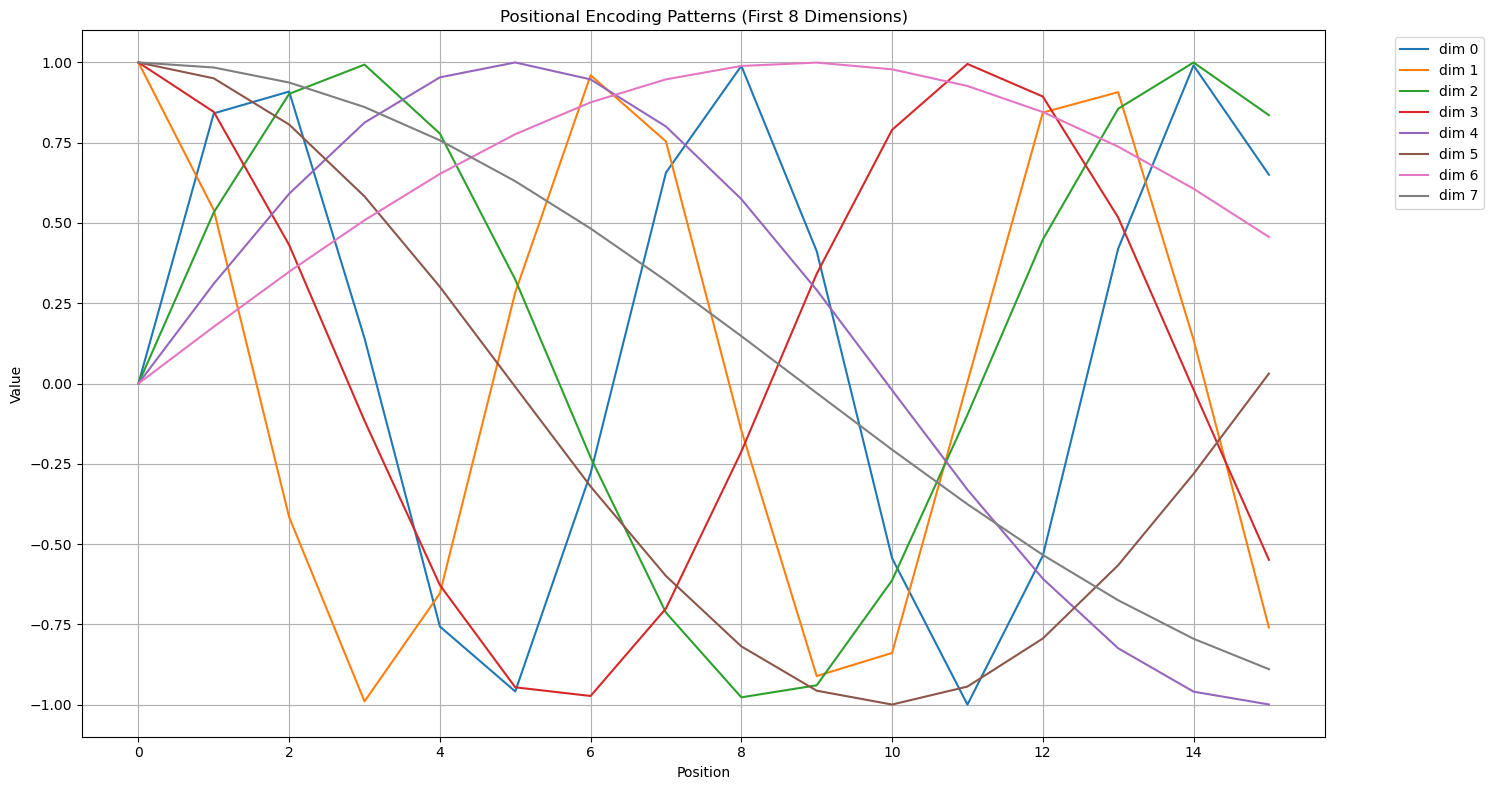

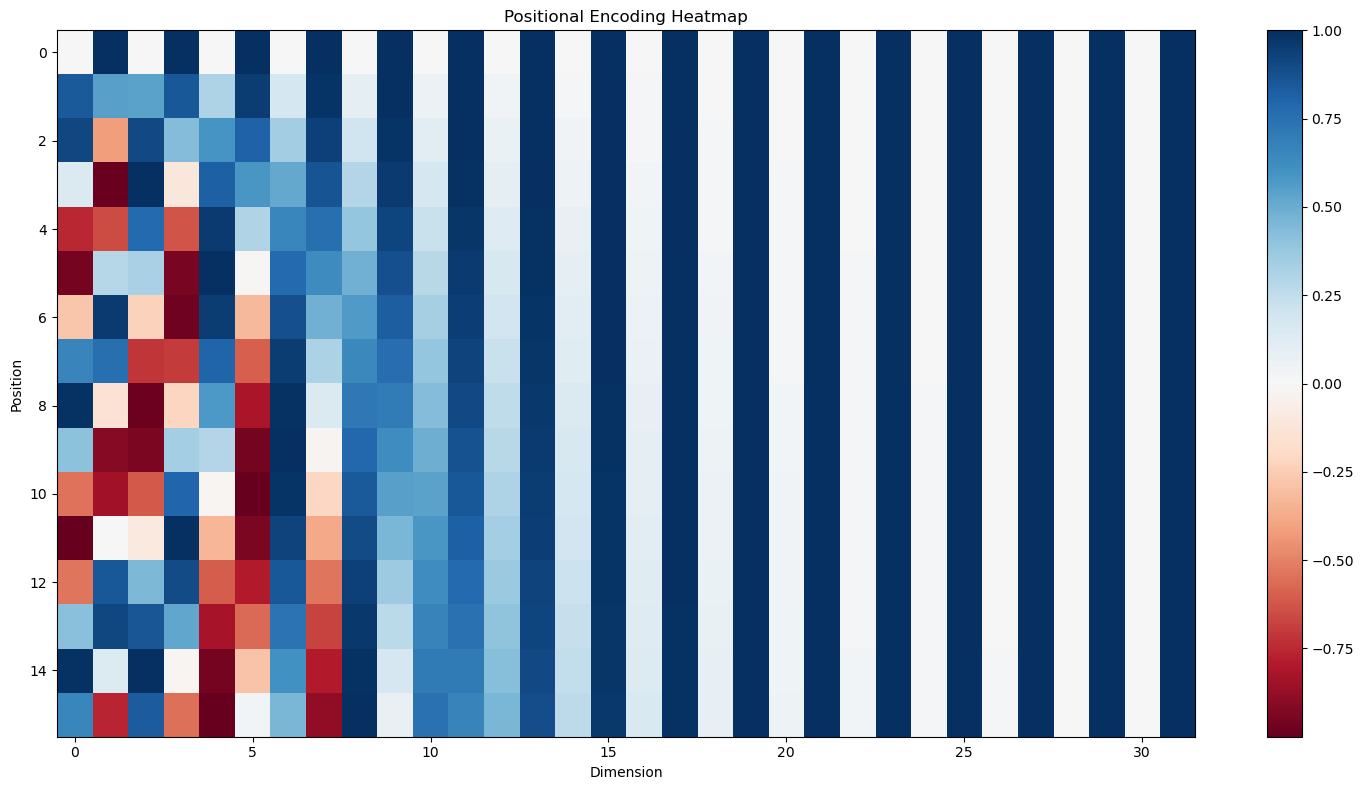

In [17]:
## Visualize positional encoding
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import matplotlib.pyplot as plt
import numpy as np

def visualize_positional_encoding(seq_length=30, d_model=32):
    # Generate positional encoding
    pe = np.zeros((seq_length, d_model))
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    
    # Plot first 8 dimensions
    for dim in range(8):
        plt.plot(pe[:, dim], label=f'dim {dim}')
    
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('Positional Encoding Patterns (First 8 Dimensions)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Also show heatmap of all dimensions
    plt.figure(figsize=(15, 8))
    plt.imshow(pe, cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding Heatmap')
    plt.tight_layout()
    plt.show()

# Using your model's positional encoding
seq_length = 16  # From your example
d_model = 768    # From your example

# You might want to use a smaller d_model for visualization
visualize_positional_encoding(seq_length=16, d_model=32)

### Attention Pattern Visualization
Shows:
- Self-attention patterns (causal masking)
- Cross-attention patterns
- Effect of padding masks
- How attention weights distribute

In [18]:
def test_decoder_causal_masking():
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 2
    seq_length = 5
    d_model = 512
    d_ff = 2048
    num_heads = 8
    
    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()
    
    decoder_input = torch.randn(batch_size, seq_length, d_model)
    encoder_output = torch.randn(batch_size, seq_length, d_model)
    
    attention_scores = []
    
    def attention_hook(module, input, output):
        if not attention_scores:
            # Apply softmax to get actual attention probabilities
            scores = F.softmax(module.att_matrix, dim=-1)
            attention_scores.append(scores.detach())
    
    decoder.att.register_forward_hook(attention_hook)
    
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output)
    
    att_weights = attention_scores[0]
    
    print("\nAttention Matrix Shape:", att_weights.shape)
    
    # Print attention pattern for first head of first batch
    print("\nAttention Pattern (first head):")
    print(att_weights[0, 0].round(decimals=4))
    
    # Check future tokens (should be 0)
    future_attention = att_weights[:, :, torch.triu_indices(seq_length, seq_length, offset=1)[0], 
                                        torch.triu_indices(seq_length, seq_length, offset=1)[1]]
    
    print("\nFuture Token Analysis:")
    print(f"Mean attention to future tokens: {future_attention.mean():.8f}")
    print(f"Max attention to future tokens: {future_attention.max():.8f}")
    print("Causal masking working:", "Yes" if future_attention.mean() < 1e-7 else "No")
    
    # Check present/past tokens
    present_past = att_weights[:, :, torch.tril_indices(seq_length, seq_length)[0],
                                    torch.tril_indices(seq_length, seq_length)[1]]
    
    print("\nPresent/Past Token Analysis:")
    print(f"Mean attention to present/past tokens: {present_past.mean():.4f}")
    print(f"Has non-zero attention patterns:", "Yes" if present_past.mean() > 0 else "No")
    
    # Verify each position's attention sums to 1
    attention_sums = att_weights.sum(dim=-1)
    print("\nAttention Sum Analysis:")
    print(f"Mean attention sum (should be 1): {attention_sums.mean():.4f}")
    print(f"Max deviation from 1: {(attention_sums - 1).abs().max():.8f}")
    
    return att_weights

attention_weights = test_decoder_causal_masking()


Attention Matrix Shape: torch.Size([2, 8, 5, 5])

Attention Pattern (first head):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4465, 0.5535, 0.0000, 0.0000, 0.0000],
        [0.3403, 0.3496, 0.3101, 0.0000, 0.0000],
        [0.1965, 0.3485, 0.1174, 0.3377, 0.0000],
        [0.1563, 0.1571, 0.1859, 0.1948, 0.3059]])

Future Token Analysis:
Mean attention to future tokens: 0.00000000
Max attention to future tokens: 0.00000000
Causal masking working: Yes

Present/Past Token Analysis:
Mean attention to present/past tokens: 0.3333
Has non-zero attention patterns: Yes

Attention Sum Analysis:
Mean attention sum (should be 1): 1.0000
Max deviation from 1: 0.00000012


In [19]:
def test_decoder_cross_attention():
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 2
    decoder_seq_len = 5
    encoder_seq_len = 7  # Different length to make it interesting!
    d_model = 512
    d_ff = 2048
    num_heads = 8
    
    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()
    
    # Create input sequences
    decoder_input = torch.randn(batch_size, decoder_seq_len, d_model)
    encoder_output = torch.randn(batch_size, encoder_seq_len, d_model)
    
    # Store attention scores
    cross_attention_scores = []
    
    def attention_hook(module, input, output):
        # We want the second call to att (cross-attention)
        if len(cross_attention_scores) < 2:
            scores = F.softmax(module.att_matrix, dim=-1)
            cross_attention_scores.append(scores.detach())
    
    decoder.att.register_forward_hook(attention_hook)
    
    # Forward pass
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output)
    
    # Get cross-attention weights (second element in list)
    cross_att_weights = cross_attention_scores[1]  # [batch, heads, decoder_seq_len, encoder_seq_len]
    
    print("\nCross-Attention Matrix Shape:", cross_att_weights.shape)
    
    # Print attention pattern for first head of first batch
    print("\nCross-Attention Pattern (first head):")
    print(cross_att_weights[0, 0].round(decimals=4))
    
    # Verify each decoder position attends to all encoder positions
    attention_sums = cross_att_weights.sum(dim=-1)
    zero_attention = (cross_att_weights == 0).all(dim=-1)
    
    print("\nCross-Attention Analysis:")
    print(f"Mean attention weight: {cross_att_weights.mean():.4f}")
    print(f"Min attention weight: {cross_att_weights.min():.4f}")
    print(f"Max attention weight: {cross_att_weights.max():.4f}")
    
    print("\nAttention Coverage:")
    print(f"Each position's attention sums to 1: {torch.allclose(attention_sums, torch.ones_like(attention_sums))}")
    print(f"Every decoder position attends to some encoder position: {not zero_attention.any()}")
    
    # Check attention distribution
    attention_entropy = -(cross_att_weights * torch.log(cross_att_weights + 1e-9)).sum(dim=-1).mean()
    print(f"\nAttention entropy (higher means more uniform attention): {attention_entropy:.4f}")
    
    return cross_att_weights

# Run the test
cross_attention_weights = test_decoder_cross_attention()


Cross-Attention Matrix Shape: torch.Size([2, 8, 5, 7])

Cross-Attention Pattern (first head):
tensor([[0.1308, 0.1502, 0.1380, 0.1131, 0.1987, 0.1117, 0.1576],
        [0.1303, 0.1041, 0.1502, 0.1756, 0.1679, 0.1589, 0.1130],
        [0.0896, 0.2159, 0.1142, 0.1718, 0.1797, 0.0844, 0.1444],
        [0.1250, 0.1650, 0.1607, 0.1053, 0.0868, 0.2349, 0.1223],
        [0.1637, 0.0842, 0.2093, 0.1223, 0.1274, 0.1392, 0.1540]])

Cross-Attention Analysis:
Mean attention weight: 0.1429
Min attention weight: 0.0389
Max attention weight: 0.4142

Attention Coverage:
Each position's attention sums to 1: True
Every decoder position attends to some encoder position: True

Attention entropy (higher means more uniform attention): 1.8917


In [20]:
def test_decoder_cross_attention_with_padding():
    torch.manual_seed(42)
    
    # Test parameters
    batch_size = 2
    decoder_seq_len = 5
    encoder_seq_len = 7
    d_model = 512
    d_ff = 2048
    num_heads = 8
    
    decoder = TransformerDecoder(
        d_model=d_model,
        d_ff=d_ff,
        num_head=num_heads,
        dropout=0.1
    )
    decoder.eval()
    
    # Create input sequences
    decoder_input = torch.randn(batch_size, decoder_seq_len, d_model)
    encoder_output = torch.randn(batch_size, encoder_seq_len, d_model)
    
    # Create padding mask for encoder outputs
    # Mask out last 2 positions (as if they were padding in encoder output)
    padding_mask = torch.ones(batch_size, decoder_seq_len, encoder_seq_len)
    padding_mask[:, :, -2:] = float('-inf')  # Mask positions 5,6
    padding_mask = padding_mask.unsqueeze(1)  # Add head dimension [batch, 1, decoder_seq, encoder_seq]
    
    cross_attention_scores = []
    
    def attention_hook(module, input, output):
        if len(cross_attention_scores) < 2:
            scores = F.softmax(module.att_matrix, dim=-1)
            cross_attention_scores.append(scores.detach())
    
    decoder.att.register_forward_hook(attention_hook)
    
    # Forward pass
    with torch.no_grad():
        output = decoder(decoder_input, encoder_output, padding_mask)
    
    # Get cross-attention weights (second element)
    cross_att_weights = cross_attention_scores[1]
    
    print("\nCross-Attention Matrix Shape:", cross_att_weights.shape)
    
    print("\nCross-Attention Pattern (first head):")
    print("(Last two encoder positions should have zero attention)")
    print(cross_att_weights[0, 0].round(decimals=4))
    
    # Analyze masked positions (last two columns)
    masked_attention = cross_att_weights[:, :, :, -2:]
    unmasked_attention = cross_att_weights[:, :, :, :-2]
    
    print("\nMasking Analysis:")
    print(f"Mean attention to masked positions: {masked_attention.mean():.8f}")
    print(f"Max attention to masked positions: {masked_attention.max():.8f}")
    print(f"Mean attention to unmasked positions: {unmasked_attention.mean():.4f}")
    
    # Verify attention still sums to 1 (only over unmasked positions)
    attention_sums = cross_att_weights.sum(dim=-1)
    
    print("\nAttention Coverage:")
    print(f"Each position's attention sums to 1: {torch.allclose(attention_sums, torch.ones_like(attention_sums), atol=1e-6)}")
    
    # Analyze attention distribution over unmasked positions
    print("\nUnmasked Position Analysis:")
    print(f"Min attention to unmasked positions: {unmasked_attention.min():.4f}")
    print(f"Max attention to unmasked positions: {unmasked_attention.max():.4f}")
    
    return cross_att_weights

# Run the test
cross_attention_weights = test_decoder_cross_attention_with_padding()


Cross-Attention Matrix Shape: torch.Size([2, 8, 5, 7])

Cross-Attention Pattern (first head):
(Last two encoder positions should have zero attention)
tensor([[0.1791, 0.2055, 0.1888, 0.1547, 0.2719, 0.0000, 0.0000],
        [0.1789, 0.1430, 0.2063, 0.2412, 0.2306, 0.0000, 0.0000],
        [0.1162, 0.2800, 0.1480, 0.2228, 0.2330, 0.0000, 0.0000],
        [0.1945, 0.2566, 0.2500, 0.1638, 0.1350, 0.0000, 0.0000],
        [0.2316, 0.1191, 0.2961, 0.1730, 0.1802, 0.0000, 0.0000]])

Masking Analysis:
Mean attention to masked positions: 0.00000000
Max attention to masked positions: 0.00000000
Mean attention to unmasked positions: 0.2000

Attention Coverage:
Each position's attention sums to 1: True

Unmasked Position Analysis:
Min attention to unmasked positions: 0.0458
Max attention to unmasked positions: 0.4875
